<a href="https://colab.research.google.com/github/vent0906/ww/blob/main/self_learn_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this project, I begin by presenting a concise implementation of the Graph Attention Network (GAT) using PyTorch Geometric (PyG). This high-level framework provides a fast and straightforward way to construct GAT models through its built-in `GATConv` layer, enabling efficient development and experimentation.

Following that, I demonstrate a more flexible, low-level implementation of GAT using DGL (Deep Graph Library), where each component of the model—such as attention computation, message passing, and multi-head aggregation—is manually defined. This approach offers greater transparency and allows for detailed customization, which is particularly useful for understanding the internal mechanisms of GAT and for research purposes.

I also compare the PyG and DGL implementations in terms of structure, abstraction, and flexibility, highlighting their respective advantages and trade-offs.

The dataset used in this study is the Cora citation network, which consists of 2,708 nodes and 10,556 edges. Each node has a 1,433-dimensional feature vector, and every node is associated with one of seven class labels. The objective of this task is to apply GAT to perform multi-class classification, predicting the label of each node based on its features and graph structure.

In [4]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import argparse
import time
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv  # Predefined Graph Attention Layer from PyTorch Geometric (PyG)

In [6]:
class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super().__init__()

        # First GAT layer: applies multi-head attention
        # Input dimension = in_dim, Output per head = hidden_dim
        # Total output dimension = hidden_dim * num_heads
        self.gat1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=0.6)

        # Second GAT layer: single-head attention (heads=1)
        # Input dimension = hidden_dim * num_heads (concatenated heads from previous layer)
        # Output dimension = out_dim
        # concat=False means the outputs from all heads will be averaged instead of concatenated
        self.gat2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        # Apply the first GAT layer to the node features and edge list
        x = self.gat1(x, edge_index)

        # Apply the ELU activation function (Exponential Linear Unit) to introduce non-linearity
        x = F.elu(x)

        # Apply the second GAT layer to obtain the final output (e.g., class logits)
        x = self.gat2(x, edge_index)

        return x  # Return the final node representations (or classification scores)

In [9]:
%%writefile handwritten_gat.py

# Define a single-head Graph Attention Layer manually using DGL framework
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g  # The DGL graph object that contains the structure of the graph
        self.fc = nn.Linear(in_dim, out_dim, bias=False)  # Linear transformation to project input features
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)  # Linear layer to compute attention scores between pairs of nodes
        self.reset_parameters()  # Initialize weights

    def reset_parameters(self):
        # Use Xavier initialization for stable training
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edges.src['z']: source node transformed features
        # edges.dst['z']: destination node transformed features
        # Concatenate source and destination features
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)  # Compute raw attention scores
        return {'e': F.leaky_relu(a)}  # Apply LeakyReLU non-linearity

    def message_func(self, edges):
        # The messages contain both the source node's feature and the attention score on each edge
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # nodes.mailbox['e']: attention scores from each neighbor
        # nodes.mailbox['z']: neighbor features
        alpha = F.softmax(nodes.mailbox['e'], dim=1)  # Normalize attention scores using softmax
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)  # Compute weighted sum of neighbor features
        return {'h': h}  # Output the aggregated feature

    def forward(self, h):
        # h: input node features
        z = self.fc(h)  # Step 1: apply linear transformation to features
        self.g.ndata['z'] = z  # Store transformed features in graph
        self.g.apply_edges(self.edge_attention)  # Step 2: compute attention scores for each edge
        self.g.update_all(self.message_func, self.reduce_func)  # Step 3 & 4: propagate and aggregate messages
        return self.g.ndata.pop('h')  # Return the updated node representations


# Multi-head GAT Layer that combines outputs from multiple attention heads
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        # Create multiple GATLayer instances (heads)
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge  # Method to merge multiple heads: 'cat' or 'mean'

    def forward(self, h):
        # Apply each attention head independently
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # Concatenate the outputs of all heads (used in the first layer)
            return torch.cat(head_outs, dim=1)
        else:
            # Average the outputs of all heads (used in the final layer)
            return torch.mean(torch.stack(head_outs), dim=0)


# The full GAT model with two layers:
# - First layer: multi-head attention with concatenation
# - Second layer: single-head attention with averaging (classification output)
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        # First layer: input → hidden_dim * num_heads (concatenated)
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Second layer: hidden → output classes, single head with mean merge
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)  # Pass through first GAT layer
        h = F.elu(h)        # Apply ELU non-linearity
        h = self.layer2(h)  # Pass through second GAT layer
        return h  # Output logits for each node

Overwriting handwritten_gat.py


## Comparison between handwritten GAT and PyTorch Geometric's GATConv

| Feature                        | Handwritten GAT (DGL)                                     | GATConv (PyTorch Geometric)                                |
|-------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| Framework                     | DGL                                                        | PyTorch Geometric (PyG)                                     |
| Attention mechanism           | Explicit MLP + LeakyReLU + Softmax                        | Internal attention, defined via learnable parameters        |
| Multi-head attention          | Manually implemented using `ModuleList` and loops         | Controlled via `heads` parameter                            |
| Message passing               | Manually defined with `message_func` and `reduce_func`    | Fully abstracted inside GATConv                             |
| Code complexity               | High – more control, more verbose                         | Low – plug-and-play with concise API                        |
| Flexibility / Customization   | Very flexible for research and theoretical modification   | Limited to structure defined in PyG                         |
| Performance / Speed           | Slightly slower due to manual operations                  | Highly optimized and GPU-accelerated                        |
| Recommended use case          | Research, deep understanding, customization               | Fast prototyping and real-world deployment                  |


In [10]:
!wget https://raw.githubusercontent.com/tkipf/pygcn/master/data/cora/cora.content -O cora.content
!wget https://raw.githubusercontent.com/tkipf/pygcn/master/data/cora/cora.cites -O cora.cites


--2025-04-21 01:01:39--  https://raw.githubusercontent.com/tkipf/pygcn/master/data/cora/cora.content
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7823427 (7.5M) [text/plain]
Saving to: ‘cora.content’

cora.content        100%[===================>]   7.46M  --.-KB/s    in 0.04s   

2025-04-21 01:01:40 (191 MB/s) - ‘cora.content’ saved [7823427/7823427]

--2025-04-21 01:01:40--  https://raw.githubusercontent.com/tkipf/pygcn/master/data/cora/cora.cites
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69928 (68K) [text/plain]
Saving

In [18]:
# Step 2.1 - Load the 'cora.content' file which contains node (paper) information
content = pd.read_csv('cora.content', sep='\t', header=None)

# Extract the paper IDs (unique identifiers for each node)
paper_ids = content[0].values

# Extract the feature matrix from the columns [1 to -2] (i.e., all columns except paper_id and label)
features = torch.tensor(content.iloc[:, 1:-1].values, dtype=torch.float32)  # shape: [num_nodes, num_features]

# Raw labels (strings like 'Neural_Networks', 'Rule_Learning', etc.)
labels_raw = content.iloc[:, -1]

# Create a set of all unique label names, and sort them to fix order
label_set = sorted(set(labels_raw))

# Map each label name (string) to an integer index
label_map = {label: i for i, label in enumerate(label_set)}

# Convert label strings to integers using the map
labels = torch.tensor([label_map[label] for label in labels_raw], dtype=torch.long)

# Step 2.2 - Create a dictionary mapping paper_id to node index
# This is used to convert citations (edges) from paper ID format to index format
paper_id_to_index = {pid: idx for idx, pid in enumerate(paper_ids)}

# Step 2.3 - Load the 'cora.cites' file which contains the citation relationships (edges)
edges_raw = pd.read_csv('cora.cites', sep='\t', header=None)

# Convert each citation from (paper_id, paper_id) to (index, index) using the map above
edge_index = torch.tensor([
    [paper_id_to_index[src], paper_id_to_index[dst]]
    for src, dst in zip(edges_raw[0], edges_raw[1])
], dtype=torch.long).t()  # Transpose to shape [2, num_edges] as required by PyG

# Step 2.4 - Construct a PyTorch Geometric Data object representing the graph
# This includes:
#   - x: the node feature matrix
#   - edge_index: the edge list in COO format
#   - y: the node labels
data = Data(x=features, edge_index=edge_index, y=labels)

# Print a summary of the data object (number of nodes, edges, features, etc.)
print(data)

print(data)

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])
Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708])


In [19]:
# Get the total number of nodes in the graph
num_nodes = data.num_nodes

# Randomly shuffle the node indices to ensure a randomized split
indices = np.random.permutation(num_nodes)

# Initialize three boolean masks for training, validation, and testing
# Initially, all entries are set to False (no node selected)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Mark the first 140 randomly chosen nodes as training nodes
train_mask[indices[:140]] = True

# Mark the next 500 nodes (140–639) as validation nodes
val_mask[indices[140:640]] = True

# The remaining nodes are assigned to the test set
test_mask[indices[640:]] = True

# Attach the masks to the PyG `data` object so they can be used during training and evaluation
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask



In [22]:
# Choose the computation device: use GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the GAT model and move it to the selected device
# - in_dim = 1433: number of input features per node (Cora)
# - hidden_dim = 8: hidden size per attention head
# - out_dim = 7: number of output classes (Cora has 7 classes)
# - num_heads = 8: number of attention heads in the first layer
model = GAT(in_dim=1433, hidden_dim=8, out_dim=7, num_heads=8).to(device)
# Move the entire data object (features, labels, edge_index, masks) to the same device as the model
data = data.to(device)
# Define the optimizer for training (Adam optimizer)
# - learning rate = 0.005
# - weight_decay = 5e-4 (L2 regularization to prevent overfitting)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
# Define the loss function: cross-entropy, suitable for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()


In [23]:
# Define training and evaluation functions for GAT using PyTorch Geometric
def train():
    model.train()  # Set the model to training mode (activates dropout, etc.)
    optimizer.zero_grad()  # Clear previous gradients
    out = model(data.x, data.edge_index)  # Forward pass: get logits for all nodes
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Compute loss only on training nodes
    loss.backward()  # Backward pass: compute gradients
    optimizer.step()  # Update model weights
    return loss.item()  # Return the loss value as a float



def test(mask):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    out = model(data.x, data.edge_index)  # Forward pass
    pred = out.argmax(dim=1)  # Choose the class with the highest predicted score
    correct = (pred[mask] == data.y[mask]).sum().item()  # Count correct predictions
    acc = correct / mask.sum().item()  # Compute accuracy
    return acc  # Return accuracy as a float
for epoch in range(200):
    loss = train()
    val_acc = test(data.val_mask)
    print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Accuracy: {val_acc:.4f}")

# Final test accuracy
test_acc = test(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")




Epoch 000 | Loss: 1.9433 | Val Accuracy: 0.4100
Epoch 001 | Loss: 1.7307 | Val Accuracy: 0.4840
Epoch 002 | Loss: 1.6229 | Val Accuracy: 0.4960
Epoch 003 | Loss: 1.5402 | Val Accuracy: 0.5020
Epoch 004 | Loss: 1.4740 | Val Accuracy: 0.5360
Epoch 005 | Loss: 1.2867 | Val Accuracy: 0.5640
Epoch 006 | Loss: 1.2501 | Val Accuracy: 0.5960
Epoch 007 | Loss: 1.2348 | Val Accuracy: 0.6120
Epoch 008 | Loss: 1.1220 | Val Accuracy: 0.6460
Epoch 009 | Loss: 1.1144 | Val Accuracy: 0.6560
Epoch 010 | Loss: 0.9793 | Val Accuracy: 0.6780
Epoch 011 | Loss: 0.9576 | Val Accuracy: 0.6920
Epoch 012 | Loss: 0.9765 | Val Accuracy: 0.7040
Epoch 013 | Loss: 0.9840 | Val Accuracy: 0.7100
Epoch 014 | Loss: 0.9413 | Val Accuracy: 0.7140
Epoch 015 | Loss: 0.7574 | Val Accuracy: 0.7220
Epoch 016 | Loss: 0.9295 | Val Accuracy: 0.7260
Epoch 017 | Loss: 0.9629 | Val Accuracy: 0.7340
Epoch 018 | Loss: 0.8517 | Val Accuracy: 0.7400
Epoch 019 | Loss: 0.8672 | Val Accuracy: 0.7400
Epoch 020 | Loss: 0.8527 | Val Accuracy:

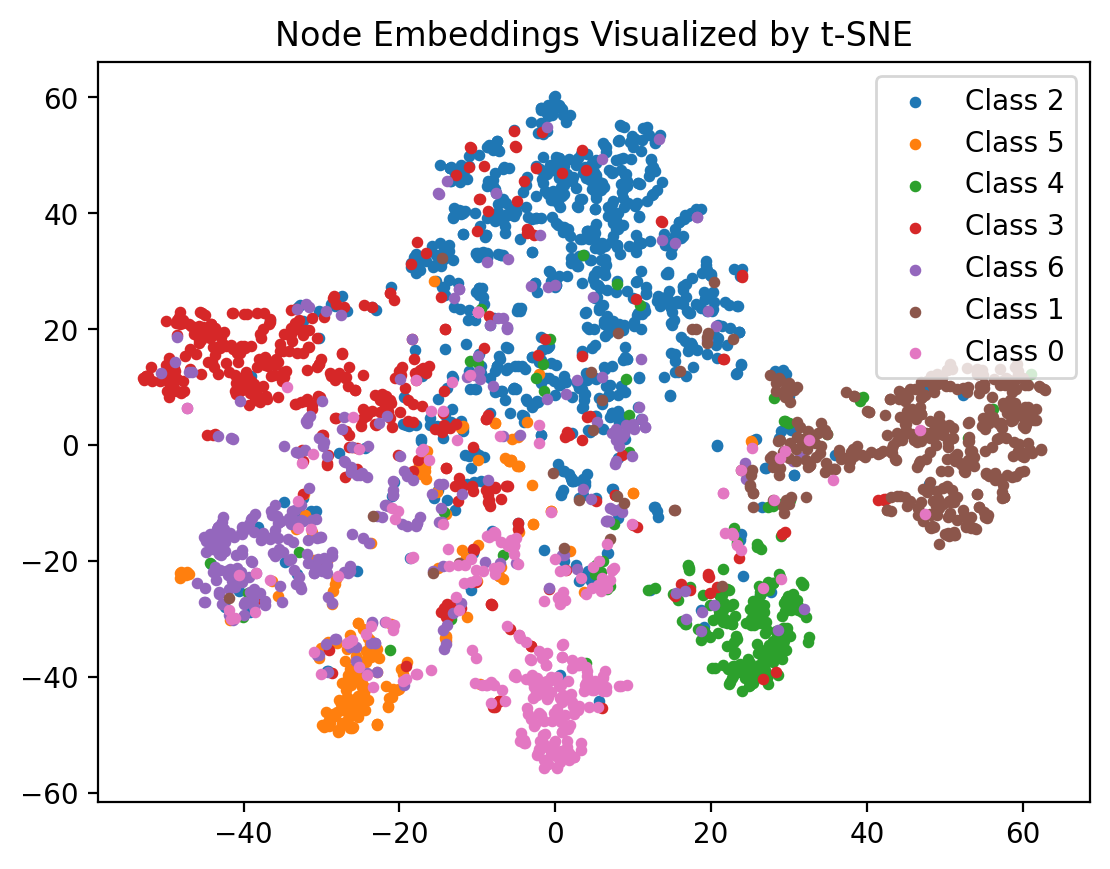

In [25]:
def plot_embeddings(embeddings, node_indices, labels):
    """
    Visualize node embeddings using t-SNE (2D).

    Parameters:
    - embeddings: numpy array of shape [num_nodes, dim]
    - node_indices: list or array of node indices to visualize
    - labels: numpy array of corresponding labels
    """
    emb_list = embeddings[node_indices]

    # Dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    node_pos = tsne.fit_transform(emb_list)

    # Group by label
    color_idx = {}
    for i in range(len(node_indices)):
        label = labels[i]
        color_idx.setdefault(label, []).append(i)

    # Plot
    plt.figure(dpi=200)
    for label, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=f"Class {label}", s=10)
    plt.legend()
    plt.title("Node Embeddings Visualized by t-SNE")
    plt.show()


# ====== Example usage (PyTorch Geometric style) ======

# Get model output (node embeddings)
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index).cpu().numpy()

# Visualize all nodes
plot_embeddings(node_embeddings, np.arange(data.num_nodes), data.y.cpu().numpy())
